# DTSA-5511:  Week 3 - Kaggle Mini Project

## Histopathologic Cancer Detection using Convolutional Neural Networks

## Part 1: Brief Description of the Problem and Data 

This project involves the identification of metastatic cancer in small image patches taken from larger digital pathology scans. This will involve building a CNN to perform binary classification of the image data. The labels will either be "positive" for the presence of cancer or negative.

The data consists of RGB images in TIF format. The training label is assigned as positive if at least one pixel in the center (32, 32) of an image contains tumorous tissue. Also in this dataset is a file labelling this data is present in CSV format. The total size of the download from Kaggle is 7.76GB.




In [1]:
# The below code is implemented simply to supress warnings when running this model on my system.

def import_tensorflow():
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

tf = import_tensorflow()    

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow.keras as keras
import cv2
import time
import visualkeras
import os
import itertools

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from collections import defaultdict
from tifffile import imread
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop

In [3]:
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.12.0



In [4]:
# Detect the presence of the GPU on this system. Also limit the memory growth to avoid having the model consume all the system memory.

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("NVidia CUDA GPU information:\n")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print(gpus)
        print("\n")
        #!nvidia-smi
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

NVidia CUDA GPU information:

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]




## Part 2: Exploratory Data Analysis (EDA)

Connect the model to the data directories on this system.

In [5]:
base_dir = '/home/doctorterry/Notebooks/DTSA5511/Week3_CNN/Data'
train_dir, test_dir = f'{base_dir}/train/', f'{base_dir}/test/'
ntrain, ntest = len(os.listdir(train_dir)), len(os.listdir(test_dir))


List the number of training and test images.

In [6]:
print(f'Number of Training Images = {ntrain}')
print(f'Number of Test Images = {ntest}\n')

Number of Training Images = 220025
Number of Test Images = 57458



Now let us examine the data labels contained in the CSV files. The file has 220025 observations with each consiting of two pieces of data:

1. A file name for the image TIF file (ID).
2. A binary label (0 = negative, 1 = positive).

In [7]:
dfTrainLabels = pd.read_csv(os.path.join(base_dir, "train_labels.csv"))
print(f" Shape = {dfTrainLabels.shape}")
dfTrainLabels.tail()

 Shape = (220025, 2)


,id,label
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0
220024,a81f84895ddcd522302ddf34be02eb1b3e5af1cb,1


Now let us actually take a look at the images themselves. The first row below shows images where that have been labelled as cancer. The second shows images that are positive for cancer. Again note that the model will only focus on the 32x32 pixel area in the center of these images.

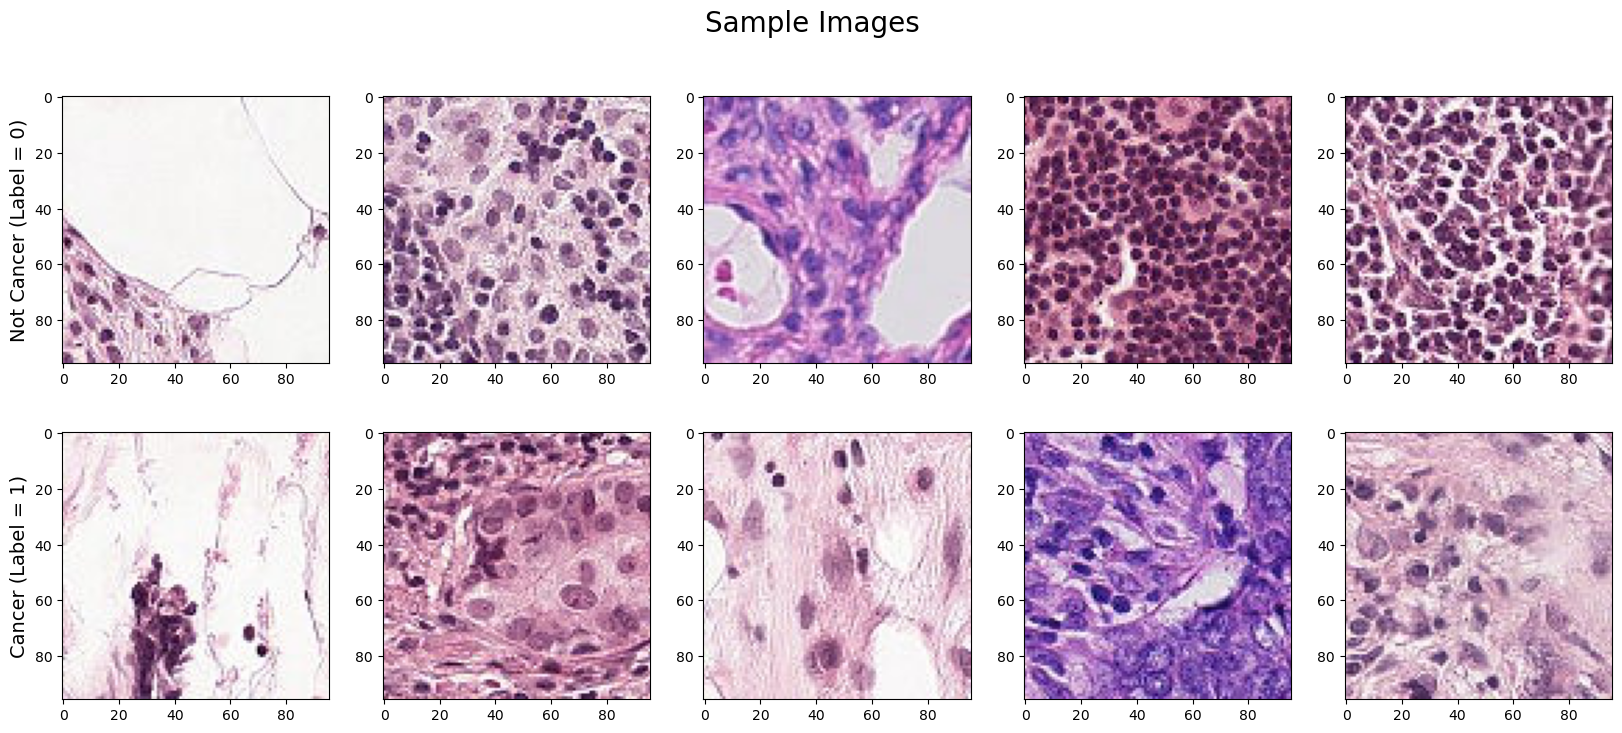

In [8]:
def makeSampleRow(row):
    for i, imageId in enumerate(dfTrainLabels[dfTrainLabels['label'] == row]['id'][:5]):
        path = os.path.join(train_dir, imageId)
        b, g, r = cv2.split(cv2.imread(path + '.tif', cv2.IMREAD_UNCHANGED))
        ax[row, i].imshow(cv2.merge([r, g, b]))
        
fig, ax = plt.subplots(2, 5, figsize = (20, 8))
fig.suptitle('Sample Images', fontsize = 20)

# The first row are images that are negative for cancer.
makeSampleRow(0)

# The second row are images that are positive for cancer.
makeSampleRow(1)

ax[0, 0].set_ylabel('Not Cancer (Label = 0)', fontsize='14')
ax[1, 0].set_ylabel('Cancer (Label = 1)',  fontsize='14')
plt.show()

Looking at the training labels, we have a much greater number of negative results than positive to train our model.

0    130908
1     89117
Name: label, dtype: int64

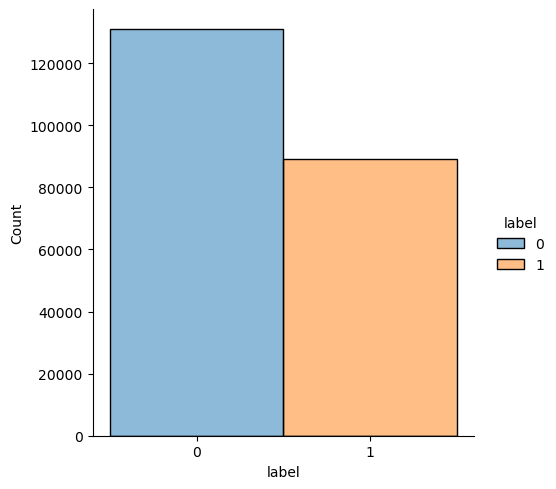

In [9]:
dfTrainLabels['label'] = dfTrainLabels['label'].astype(str)

sns.displot(data=dfTrainLabels, x='label', hue='label')
dfTrainLabels['label'].value_counts()

##  Part 3: Model Architecture

Before building and training the model, we will need to prepare the data. We will first need to merge the file IDs with ".tif" so the images could be read correctly.

In [10]:
dfTrainLabels['id'] = dfTrainLabels['id'] + '.tif'

We will use the ImageDataGenerator to read in the TIF images in to Keras. We will also be rescaling the pixels values so that instead of being between 0 and 255, they will be between 0 and 1. Lastly, the training data will be split in this process to create our train and validation datasets. Because of the large amount of data, a ratio of 0.10 was used for the validation set. 

In [11]:
generator = ImageDataGenerator(rescale = 1.0 / 255, validation_split = 0.1)

Now we will create the train and validation datasets.

In [12]:
batch_size, im_size = 256, (96, 96)

train_data = generator.flow_from_dataframe(
    dataframe = dfTrainLabels,
    x_col = 'id', # filenames
    y_col = 'label', # labels
    directory = train_dir,
    subset = 'training',
    class_mode = 'binary',
    batch_size = batch_size,
    target_size = im_size)

val_data = generator.flow_from_dataframe(
    dataframe = dfTrainLabels,
    x_col = 'id', # filenames
    y_col = 'label', # labels
    directory = train_dir,
    subset = "validation",
    class_mode = 'binary',
    batch_size = batch_size,
    target_size = im_size)

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.


### Model 1

The first model to be tried is a very simple model that is similar to what was shown in the lectures. 

* This initial model uses a simple VGG structure with a kernel of 3x3 was chosen as the base model. 
* The 3x3 kernel is able to capture more aspects of the image compared to bigger filters which summarizes a larger space which may lose out on some information (especially important since we are searching for very small signs of cancer).
* For feature extraction, the model will use 3 C-C-M (Convolution - Convolution - MaxPool) layers. 
* The first C-C-M layer will use 32 filters, the second will use 64 filters, and the third layer will use 128 filters. 
* All three layers will use ReLU activation.
* For classification, three dense layers, all using ReLU activation, will be implemented. 
* There will be a fourth final output dense layer. Given this is a binary classification problem (ie whether the image is positive or negative for cancer), a sigmoid activation is used.

In [13]:
def buildModel1():
    
    # Mini-batches are of size 32. Images are of shape (96, 96, 3)
    #batch_size = 256
    batch_size = 32
    image_shape = (96, 96, 3)
    batch_input_shape = (batch_size, 96, 96, 3)
    
    model = Sequential()

    
    # 1) CNN (Convolutional Layers) = Feature Extractor
    
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation = "relu", batch_input_shape = batch_input_shape))
    #model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"))
    model.add(MaxPool2D(pool_size = (2, 2)))

    
    # 2) ANN (Fully-Connected Dense Layers) = Binary Classification
    
    model.add(Flatten())
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    
    # Since we are doing binary class classification, the sigmoid activation is used for the output layer.
    model.add(Dense(units = 1, activation = 'sigmoid'))    

    #model.build(input_shape = batch_input_shape)
    model.build()

    model.summary()
    
    return(model)

The build summary for model 1 and a visual representation.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 96, 96, 32)          896       
                                                                 
 conv2d_1 (Conv2D)           (32, 94, 94, 32)          9248      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 47, 47, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (32, 45, 45, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (32, 43, 43, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 21, 21, 64)         0         
 2D)                                                    

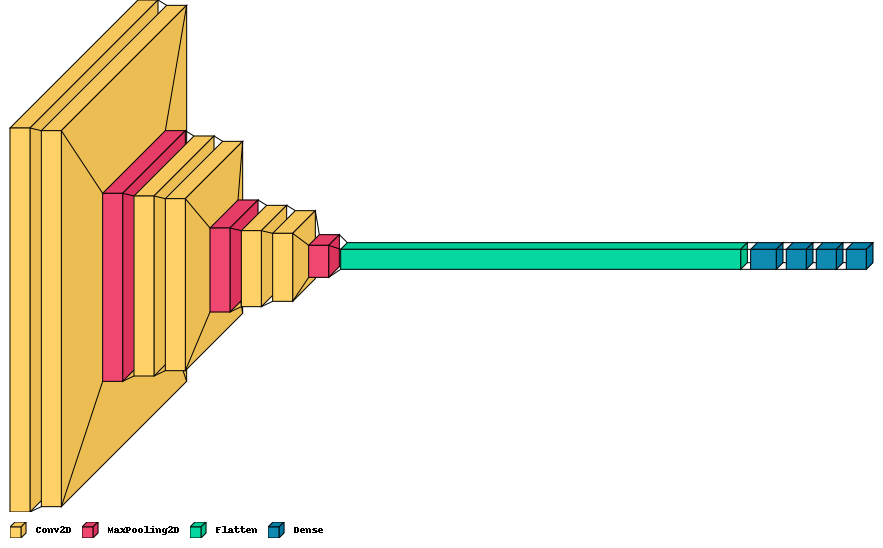

In [14]:
model1 = buildModel1()
print("\n\n")
visualkeras.layered_view(model1, legend=True)

For model 1, Adam will be used as the optimizer with the default learning rate (0.0001). For loss, binary crossentropy is used. We will fit this model over 10 epochs.

In [15]:
model1_opt = Adam(learning_rate = 0.0001)
model1_epochs = 10

startTime1 = time.time()
model1.compile(optimizer = model1_opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

'''
** NOTE ** Be careful with the "steps per epoch". It does speed up training considerably. However, if the value is too big, it will
           negatively affect the accuracy of the model. This will not be used when finalizing the result at the end of this notebook.
''' 
#history1 = model1.fit(train_data, validation_data = val_data, epochs = model1_epochs)
history1 = model1.fit(train_data, validation_data = val_data, epochs = model1_epochs, steps_per_epoch = len(train_data) / 5)
endTime1 = time.time()

Epoch 1/10
154/154 [==============================] - 53s 296ms/step - loss: 0.5438 - accuracy: 0.7169 - val_loss: 0.4673 - val_accuracy: 0.7886
Epoch 2/10
154/154 [==============================] - 44s 287ms/step - loss: 0.4755 - accuracy: 0.7805 - val_loss: 0.4636 - val_accuracy: 0.7848
Epoch 3/10
154/154 [==============================] - 43s 275ms/step - loss: 0.4507 - accuracy: 0.7946 - val_loss: 0.4425 - val_accuracy: 0.7991
Epoch 4/10
154/154 [==============================] - 43s 276ms/step - loss: 0.4431 - accuracy: 0.7987 - val_loss: 0.4315 - val_accuracy: 0.8069
Epoch 5/10
154/154 [==============================] - 43s 278ms/step - loss: 0.4357 - accuracy: 0.8006 - val_loss: 0.4197 - val_accuracy: 0.8119
Epoch 6/10
154/154 [==============================] - 44s 282ms/step - loss: 0.4242 - accuracy: 0.8103 - val_loss: 0.4093 - val_accuracy: 0.8178
Epoch 7/10
154/154 [==============================] - 43s 275ms/step - loss: 0.4018 - accuracy: 0.8218 - val_loss: 0.3892 - val_ac

We will now observe the results for model 1.

The final results for model 1:

Training Time = 7.346 minutes
Accuracy = 0.833
Loss = 0.38
Validation Accuracy = 0.836
Validation Loss = 0.373




<function matplotlib.pyplot.show(close=None, block=None)>

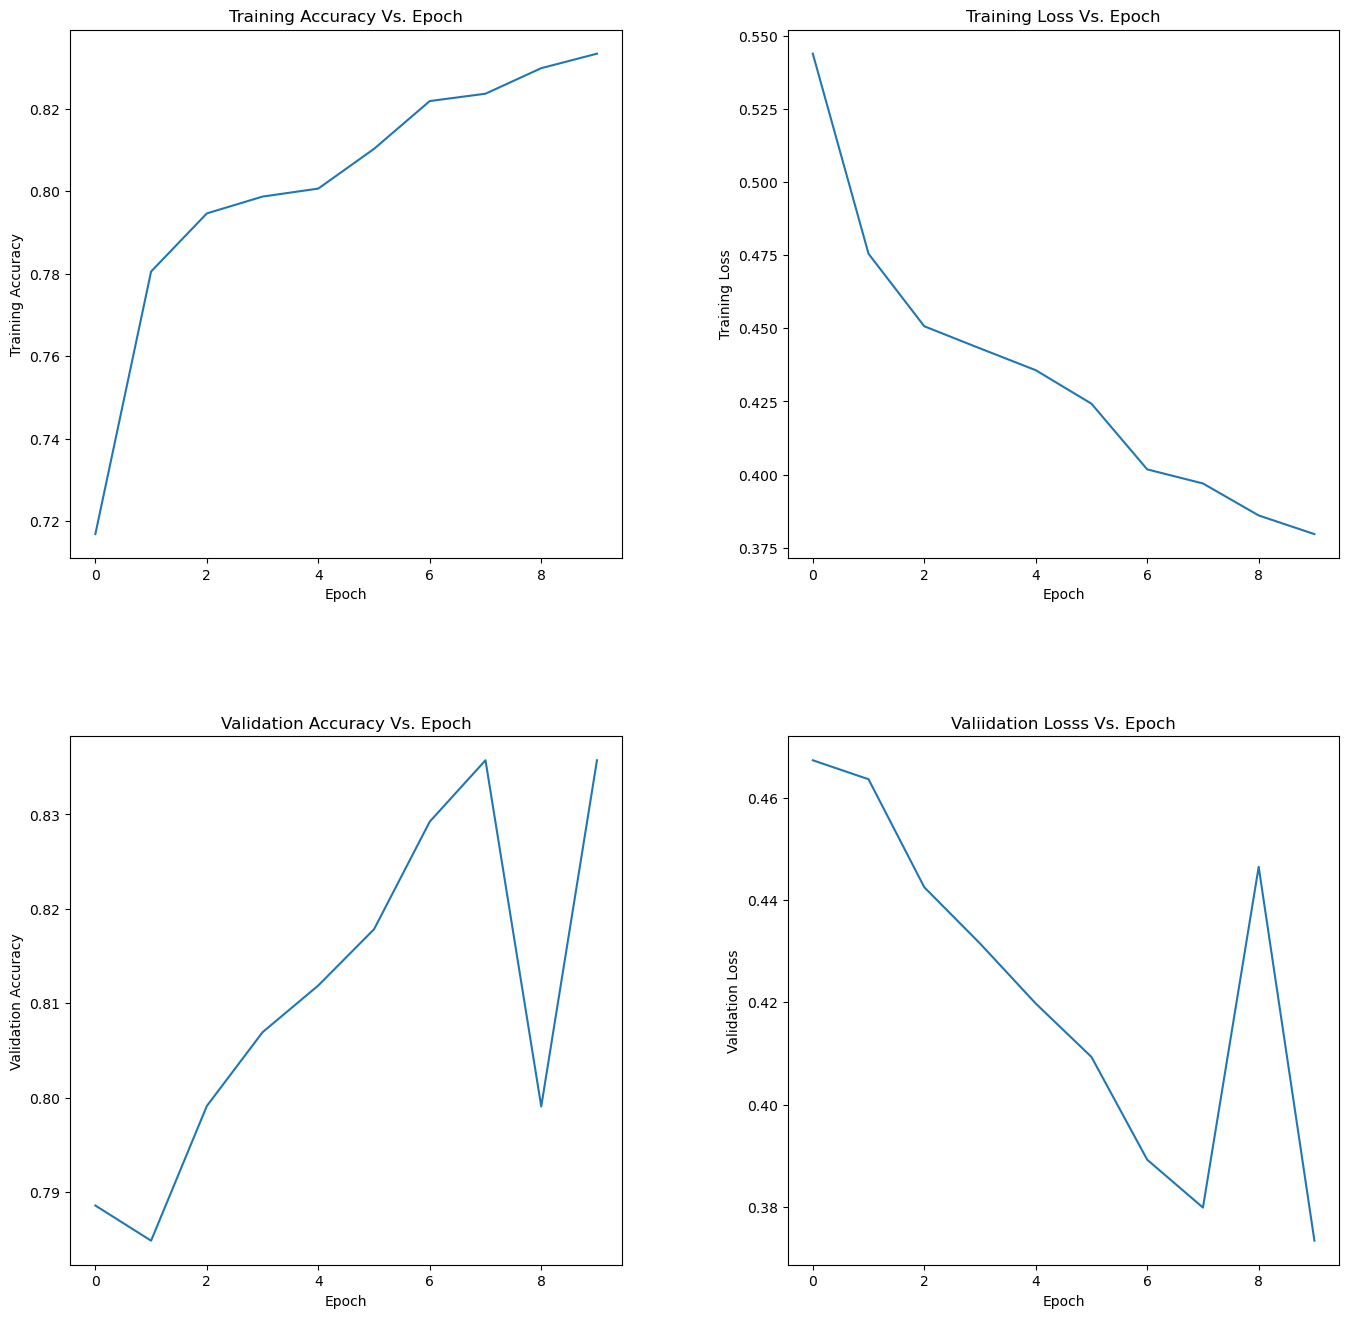

In [16]:
model1_accuracy = round((history1.history["accuracy"][model1_epochs - 1]), 3)
model1_loss = round((history1.history["loss"][model1_epochs - 1]), 3)
model1_val_accuracy = round((history1.history["val_accuracy"][model1_epochs - 1]), 3)
model1_val_loss = round((history1.history["val_loss"][model1_epochs - 1]), 3)
model1_train_time = round((endTime1 - startTime1) / 60, 3)

print("The final results for model 1:")
print(f"\nTraining Time = {model1_train_time} minutes")
print(f"Accuracy = {model1_accuracy}")
print(f"Loss = {model1_loss}")
print(f"Validation Accuracy = {model1_val_accuracy}")
print(f"Validation Loss = {model1_val_loss}\n\n")

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
figure.tight_layout(pad = 2)
figure.set_figheight(15)
figure.set_figwidth(15)

# Make a nice visualization of our test model: Training Accuracy Vs. Epoch
testAccs = history1.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[0, 0].plot(epochs, testAccs)
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Training Accuracy")
axis[0, 0].set_title("Training Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history1.history["loss"]
axis[0, 1].plot(epochs, testLosses)
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Training Loss")
axis[0, 1].set_title("Training Loss Vs. Epoch")

# Make a nice visualization of our test model: Validation Accuracy Vs. Epoch
testAccs = history1.history["val_accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[1, 0].plot(epochs, testAccs)
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Validation Accuracy")
axis[1, 0].set_title("Validation Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history1.history["val_loss"]
axis[1, 1].plot(epochs, testLosses)
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("Validation Loss")
axis[1, 1].set_title("Valiidation Losss Vs. Epoch")

plt.show

#### Analysis

* A very good start with model 1. 
* The training and validation accuracies are nearly identical at 84%. 
* There is some jitter in the losses, but this model was only run for 10 epochs, thus even a slight jitter will have much more of an impact.

### Model 2

The second model will build on the first. Below are the key changes:

* Batch normalization layers have been added at the end of each C-C-M group. The batch normalization layer should help prevent overfitting.
* Two dropout layers have been added to the ANN. The first is at the beginning of the ANN (right after the flatten operation). The second dropout has been added just prior to the output dense layer. 
* A learning rate schedule to prevent variance at the end of training.
* A callback lists has been implemented. This will have an impact during fitting with the impact being that the max number of epochs may not be used if there is no noticeable improvement to the model. This will become much more useful later during hyperparameter tuning.

In [17]:
def buildModel2():
    
    # Mini-batches are of size 32. Images are of shape (96, 96, 3)
    batch_size = 32
    image_shape = (96, 96, 3)
    batch_input_shape = (batch_size, 96, 96, 3)
    
    model = Sequential()

    
    # 1) CNN (Convolutional Layers) = Feature Extractor
    
    model.add(Conv2D(32, kernel_size = 3, padding="same", activation = "relu", batch_input_shape = batch_input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    # Down-sample feature map size by a factor of 2 (a 2x2 filter)
    model.add(MaxPool2D(pool_size = (2, 2)))
    # Normalize to prevent overfitting
    model.add(BatchNormalization(axis = -1)) 

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    # Down-sample feature map size by a factor of 2 (a 2x2 filter)
    model.add(MaxPool2D(pool_size = (2, 2)))
    # Normalize to prevent overfitting
    model.add(BatchNormalization(axis = -1)) 

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
    # Down-sample feature map size by a factor of 2 (a 2x2 filter)
    model.add(MaxPool2D(pool_size = (2, 2)))
    # Normalize to prevent overfitting
    model.add(BatchNormalization(axis = -1)) 
    
    # 2) ANN (Fully-Connected Dense Layers) = Binary Classification
    
    model.add(Flatten())
    # Dropout layer randomly sets input units to 0 which helps prevent overfitting
    model.add(Dropout(0.25))
    model.add(Dense(256, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    # Dropout layer randomly sets input units to 0 which helps prevent overfitting
    model.add(Dropout(0.25))
    model.add(Dense(32, activation = "relu"))
    
    # Since we are doing binary class classification, the sigmoid activation is used for the output layer.
    model.add(Dense(1, activation = "sigmoid"))

    #model.build(input_shape = batch_input_shape)
    model.build()
    
    model.summary()
    
    return(model)

The build summary for model 2 and a visual representation.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (32, 96, 96, 32)          896       
                                                                 
 conv2d_7 (Conv2D)           (32, 94, 94, 32)          9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 47, 47, 32)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (32, 47, 47, 32)         128       
 ormalization)                                                   
                                                                 
 conv2d_8 (Conv2D)           (32, 45, 45, 64)          18496     
                                                                 
 conv2d_9 (Conv2D)           (32, 43, 43, 64)         

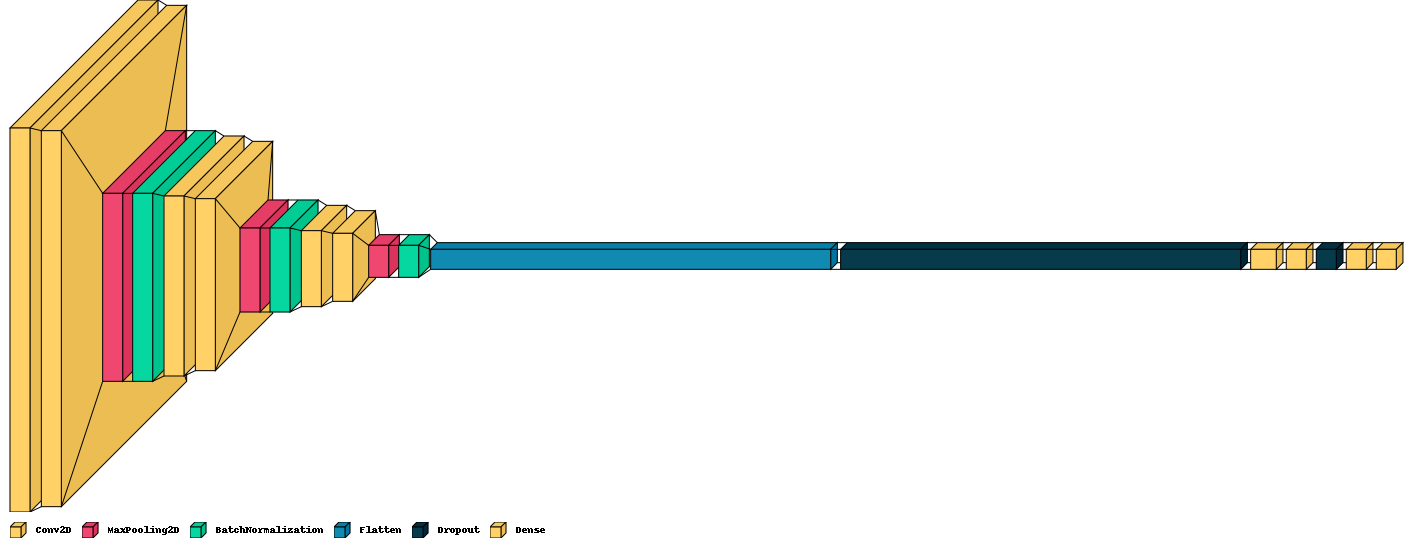

In [18]:
model2 = buildModel2()
print("\n\n")
visualkeras.layered_view(model2, legend=True)

For model 2, Adam again will be used as the optimizer. However, the optimizer will use a learning rate scheduler with an exponential decay rather than a fixed learning rate. Binary crossentropy will be used to calculate loss. Finally, a callbacks list will be implemented, though because only 10 epochs will be used, there will be little if any impact.

In [19]:
# Make a learning rate schedule to prevent variance at the end of training.
eta = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = eta, decay_steps = 10000, decay_rate = 0.9)
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10, mode = "min")]
model2_opt = Adam(learning_rate = lr_schedule)
model2_epochs = 10

In [20]:
model2.compile(optimizer = model2_opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
startTime2 = time.time()

'''
** NOTE ** Be careful with the "steps per epoch". It does speed up training considerably. However, if the value is too big, it will
           negatively affect the accuracy of the model. This will not be used when finalizing the result at the end of this notebook.
''' 
#history2 = model2.fit(train_data, validation_data = val_data, epochs = 2, callbacks = callbacks_list)
history2 = model2.fit(train_data, validation_data = val_data, epochs = model2_epochs, callbacks = callbacks_list, steps_per_epoch = len(train_data) / 5)
endTime2 = time.time()

Epoch 1/10
154/154 [==============================] - 44s 274ms/step - loss: 0.4680 - accuracy: 0.7866 - val_loss: 1.2502 - val_accuracy: 0.4037
Epoch 2/10
154/154 [==============================] - 43s 274ms/step - loss: 0.4051 - accuracy: 0.8198 - val_loss: 2.6665 - val_accuracy: 0.4037
Epoch 3/10
154/154 [==============================] - 42s 272ms/step - loss: 0.3796 - accuracy: 0.8368 - val_loss: 1.5433 - val_accuracy: 0.5499
Epoch 4/10
154/154 [==============================] - 43s 275ms/step - loss: 0.3567 - accuracy: 0.8472 - val_loss: 0.6654 - val_accuracy: 0.7291
Epoch 5/10
154/154 [==============================] - 43s 275ms/step - loss: 0.3408 - accuracy: 0.8541 - val_loss: 0.3636 - val_accuracy: 0.8433
Epoch 6/10
154/154 [==============================] - 43s 279ms/step - loss: 0.3259 - accuracy: 0.8621 - val_loss: 0.3312 - val_accuracy: 0.8615
Epoch 7/10
154/154 [==============================] - 43s 275ms/step - loss: 0.3147 - accuracy: 0.8677 - val_loss: 0.3691 - val_ac

We will now observe the results for model 2.

The final results for model 2:

Training Time = 7.133 minutes
Accuracy = 0.887
Loss = 0.278
Validation Accuracy = 0.866
Validation Loss = 0.312




<function matplotlib.pyplot.show(close=None, block=None)>

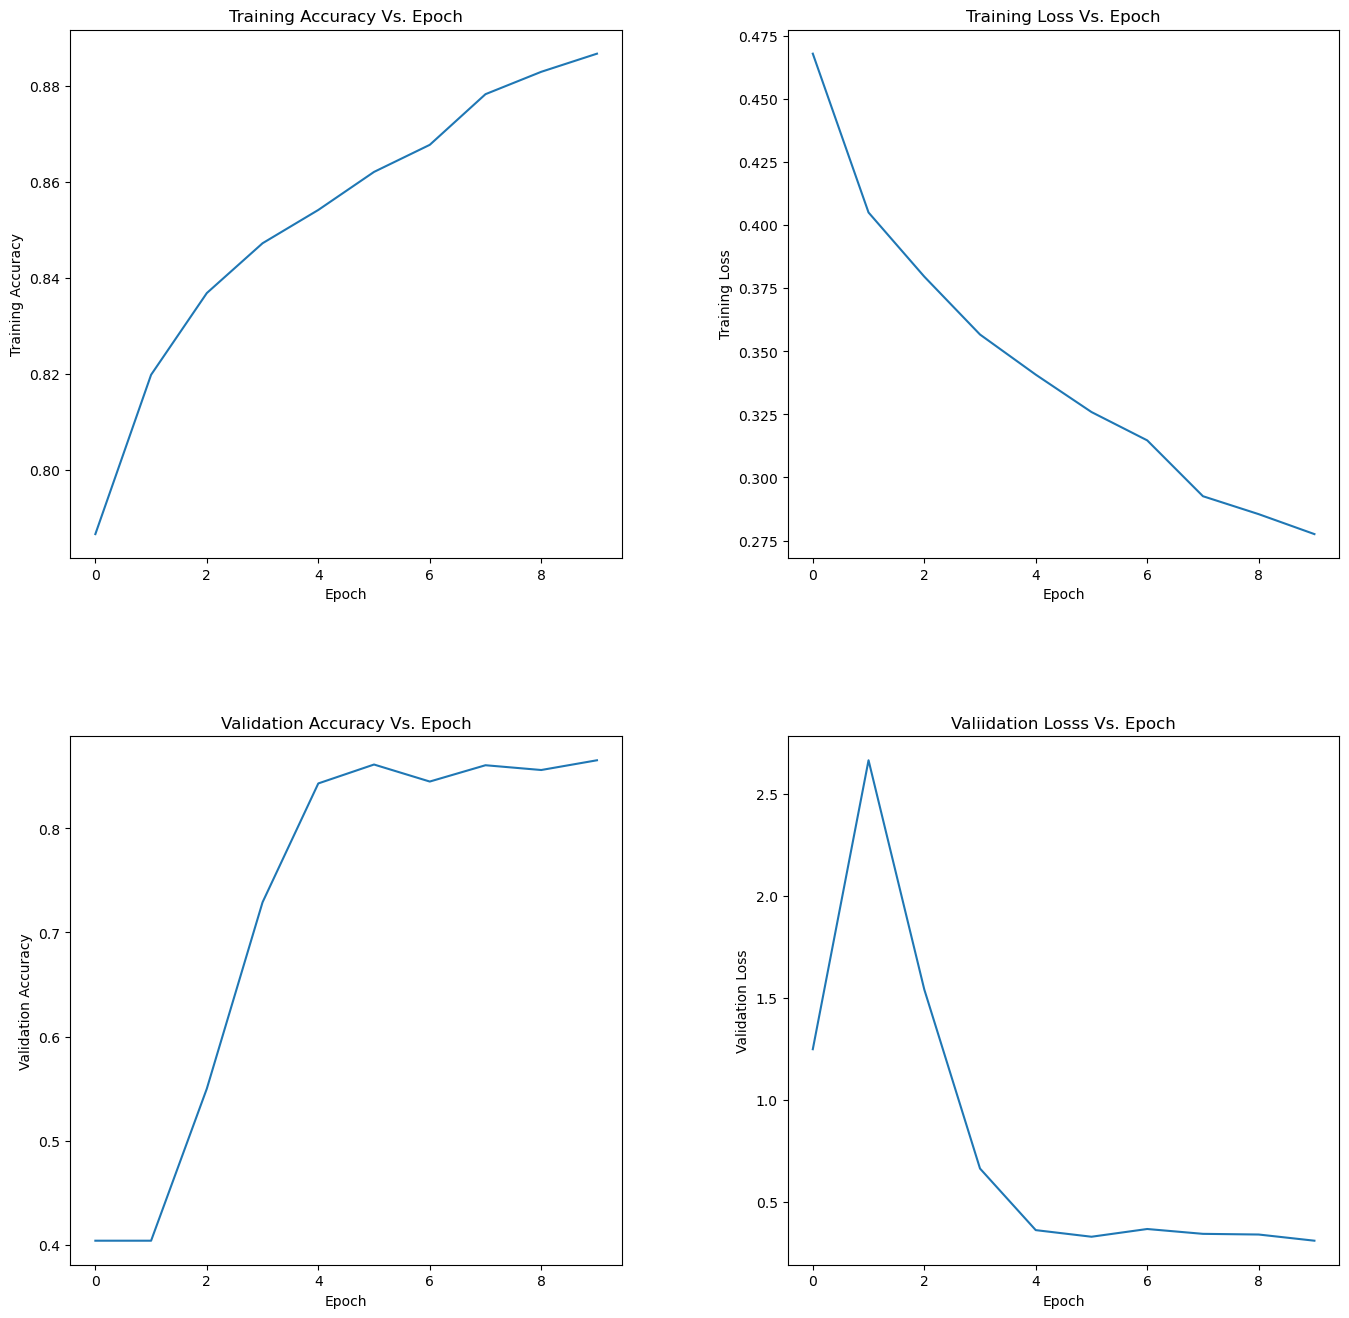

In [21]:
model2_accuracy = round((history2.history["accuracy"][model2_epochs - 1]), 3)
model2_loss = round((history2.history["loss"][model2_epochs - 1]), 3)
model2_val_accuracy = round((history2.history["val_accuracy"][model2_epochs - 1]), 3)
model2_val_loss = round((history2.history["val_loss"][model2_epochs - 1]), 3)
model2_train_time = round((endTime2 - startTime2) / 60, 3)

print("The final results for model 2:")
print(f"\nTraining Time = {model2_train_time} minutes")
print(f"Accuracy = {model2_accuracy}")
print(f"Loss = {model2_loss}")
print(f"Validation Accuracy = {model2_val_accuracy}")
print(f"Validation Loss = {model2_val_loss}\n\n")

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
figure.tight_layout(pad = 2)
figure.set_figheight(15)
figure.set_figwidth(15)

# Make a nice visualization of our test model: Training Accuracy Vs. Epoch
testAccs = history2.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[0, 0].plot(epochs, testAccs)
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Training Accuracy")
axis[0, 0].set_title("Training Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history2.history["loss"]
axis[0, 1].plot(epochs, testLosses)
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Training Loss")
axis[0, 1].set_title("Training Loss Vs. Epoch")

# Make a nice visualization of our test model: Validation Accuracy Vs. Epoch
testAccs = history2.history["val_accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[1, 0].plot(epochs, testAccs)
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Validation Accuracy")
axis[1, 0].set_title("Validation Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history2.history["val_loss"]
axis[1, 1].plot(epochs, testLosses)
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("Validation Loss")
axis[1, 1].set_title("Valiidation Losss Vs. Epoch")

plt.show

#### Analysis

* Some improvement with model 2. 
* The training accuracy increased to nearly 89%. 
* The validation accuracy is now 86%. 
* There is again some jitter in the losses, but to again point out that the model was only run for 10 epochs.

### Model 3

We will now tune two sets of hyperparameters from the previous model 2 to potentially build a better model. The below two parameters will be tuned in the model:

* Initial learning rate (eta)
* Optimizers (Adam, RMSprop)

The hyperparameter tuning will be run for a greater number of epochs than models 1 and 2. This will be to a maximum of 10 epochs.

In [28]:
eta_to_try = [0.0001, 0.001, 0.005, 0.01]
opt_Adam = Adam(learning_rate = lr_schedule)
opt_RMSprop = RMSprop(learning_rate = lr_schedule)
optimizers_to_try = [opt_Adam, opt_RMSprop]
model3_epochs = 10

hpPermutations = list(itertools.product(*[eta_to_try, optimizers_to_try]))
current_best_model = (None, 0)
current_best_history = None
current_best_hp = None

model_accuracies = list()
model3 = buildModel2()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (32, 96, 96, 32)          896       
                                                                 
 conv2d_25 (Conv2D)          (32, 94, 94, 32)          9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 47, 47, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Batc  (32, 47, 47, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_26 (Conv2D)          (32, 45, 45, 64)          18496     
                                                                 
 conv2d_27 (Conv2D)          (32, 43, 43, 64)         

The below code will loop through the hyperparameters to find the best combination.

In [29]:
startTime3 = time.time()
for hpList in hpPermutations:
    print("\n\nNow trying hyperparams:", hpList)
    this_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = hpList[0], decay_steps = 10000, decay_rate = 0.9)
    model3.compile(optimizer = hpList[1], loss = 'binary_crossentropy', metrics = ['accuracy'])

    '''
    ** NOTE ** Be careful with the "steps per epoch". It does speed up training considerably. However, if the value is too big, it will
           negatively affect the accuracy of the model. This will not be used when finalizing the result at the end of this notebook.
    ''' 
    this_history = model3.fit(train_data, validation_data = val_data, epochs = model3_epochs, steps_per_epoch = len(train_data) / 10, callbacks = callbacks_list)
    if this_history.history["accuracy"][-1] > current_best_model[1]:
        current_best_model = (model3, this_history.history["accuracy"][-1])
        current_best_history = this_history.history
        current_best_hp = hpList
        
endTime3 = time.time()
print("Total HP optimization time:", round((endTime3 - startTime3) / 60, 3), "minutes")



Now trying hyperparams: (0.0001, <keras.optimizers.legacy.adam.Adam object at 0x7fc7b9266d70>)
Epoch 1/10
77/77 [==============================] - 33s 404ms/step - loss: 0.4779 - accuracy: 0.7823 - val_loss: 0.8083 - val_accuracy: 0.4037
Epoch 2/10
77/77 [==============================] - 30s 386ms/step - loss: 0.4311 - accuracy: 0.8083 - val_loss: 1.5928 - val_accuracy: 0.4037
Epoch 3/10
77/77 [==============================] - 29s 373ms/step - loss: 0.4138 - accuracy: 0.8154 - val_loss: 2.0215 - val_accuracy: 0.4037
Epoch 4/10
77/77 [==============================] - 31s 399ms/step - loss: 0.3809 - accuracy: 0.8349 - val_loss: 2.7688 - val_accuracy: 0.4037
Epoch 5/10
77/77 [==============================] - 32s 414ms/step - loss: 0.3811 - accuracy: 0.8333 - val_loss: 3.0098 - val_accuracy: 0.4037
Epoch 6/10
77/77 [==============================] - 37s 482ms/step - loss: 0.3723 - accuracy: 0.8400 - val_loss: 1.6901 - val_accuracy: 0.4754
Epoch 7/10
77/77 [===========================

In [35]:
best_model_acc = round(current_best_model[1], 3)

print(f"The accuracy of the best hyperparameters is {best_model_acc}%")

The accuracy of the best hyperparameters is 0.958%


The final model will use the below hyperparameters:

* Learning Rate = 0.01
* Optimizer = RMSprop

In [36]:
current_best_hp

(0.01, <keras.optimizers.legacy.rmsprop.RMSprop at 0x7fc7b9266530>)

### Model 4: Final Model

We will now build the final model using the hyperparameters from the model 3 testing. There will not be any shortcuts when building this model. It will be trained on the full dataset and to the maximum of 90 epochs.

In [37]:
model4 = buildModel2()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (32, 96, 96, 32)          896       
                                                                 
 conv2d_37 (Conv2D)          (32, 94, 94, 32)          9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 47, 47, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (32, 47, 47, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_38 (Conv2D)          (32, 45, 45, 64)          18496     
                                                                 
 conv2d_39 (Conv2D)          (32, 43, 43, 64)         

In [38]:
lr_schedule_model4 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = 10000, decay_rate = 0.9)
opt_RMSprop_model4 = RMSprop(learning_rate = lr_schedule_model4)
model4_epochs = 90

model4.compile(optimizer = opt_RMSprop_model4, loss = 'binary_crossentropy', metrics = ['accuracy'])

startTime4 = time.time()

'''
** NOTE ** Be careful with the "steps per epoch". It does speed up training considerably. However, if the value is too big, it will
           negatively affect the accuracy of the model. This will not be used when finalizing the result at the end of this notebook.
''' 
history4 = model4.fit(train_data, validation_data = val_data, epochs = model4_epochs, callbacks = callbacks_list)
#history4 = model4.fit(train_data, validation_data = val_data, epochs = model4_epochs, callbacks = callbacks_list, steps_per_epoch = len(train_data) / 5)
endTime4 = time.time()

Epoch 1/90
774/774 [==============================] - 158s 202ms/step - loss: 0.6482 - accuracy: 0.8001 - val_loss: 0.8149 - val_accuracy: 0.6920
Epoch 2/90
774/774 [==============================] - 154s 198ms/step - loss: 0.3038 - accuracy: 0.8789 - val_loss: 7.3707 - val_accuracy: 0.6352
Epoch 3/90
774/774 [==============================] - 155s 200ms/step - loss: 0.2656 - accuracy: 0.8970 - val_loss: 4.0116 - val_accuracy: 0.6767
Epoch 4/90
774/774 [==============================] - 155s 201ms/step - loss: 0.2445 - accuracy: 0.9091 - val_loss: 1.8779 - val_accuracy: 0.7129
Epoch 5/90
774/774 [==============================] - 154s 199ms/step - loss: 0.2368 - accuracy: 0.9133 - val_loss: 0.4112 - val_accuracy: 0.8477
Epoch 6/90
774/774 [==============================] - 155s 200ms/step - loss: 0.2341 - accuracy: 0.9155 - val_loss: 0.2942 - val_accuracy: 0.8808
Epoch 7/90
774/774 [==============================] - 156s 201ms/step - loss: 0.2247 - accuracy: 0.9190 - val_loss: 0.2676 -

## Part 4: Results and Analysis

We will now observe the final results.

The final results for model 4:

Training Time = 93.232 minutes
Accuracy = 0.932
Loss = 0.214
Validation Accuracy = 0.774
Validation Loss = 1.082




<function matplotlib.pyplot.show(close=None, block=None)>

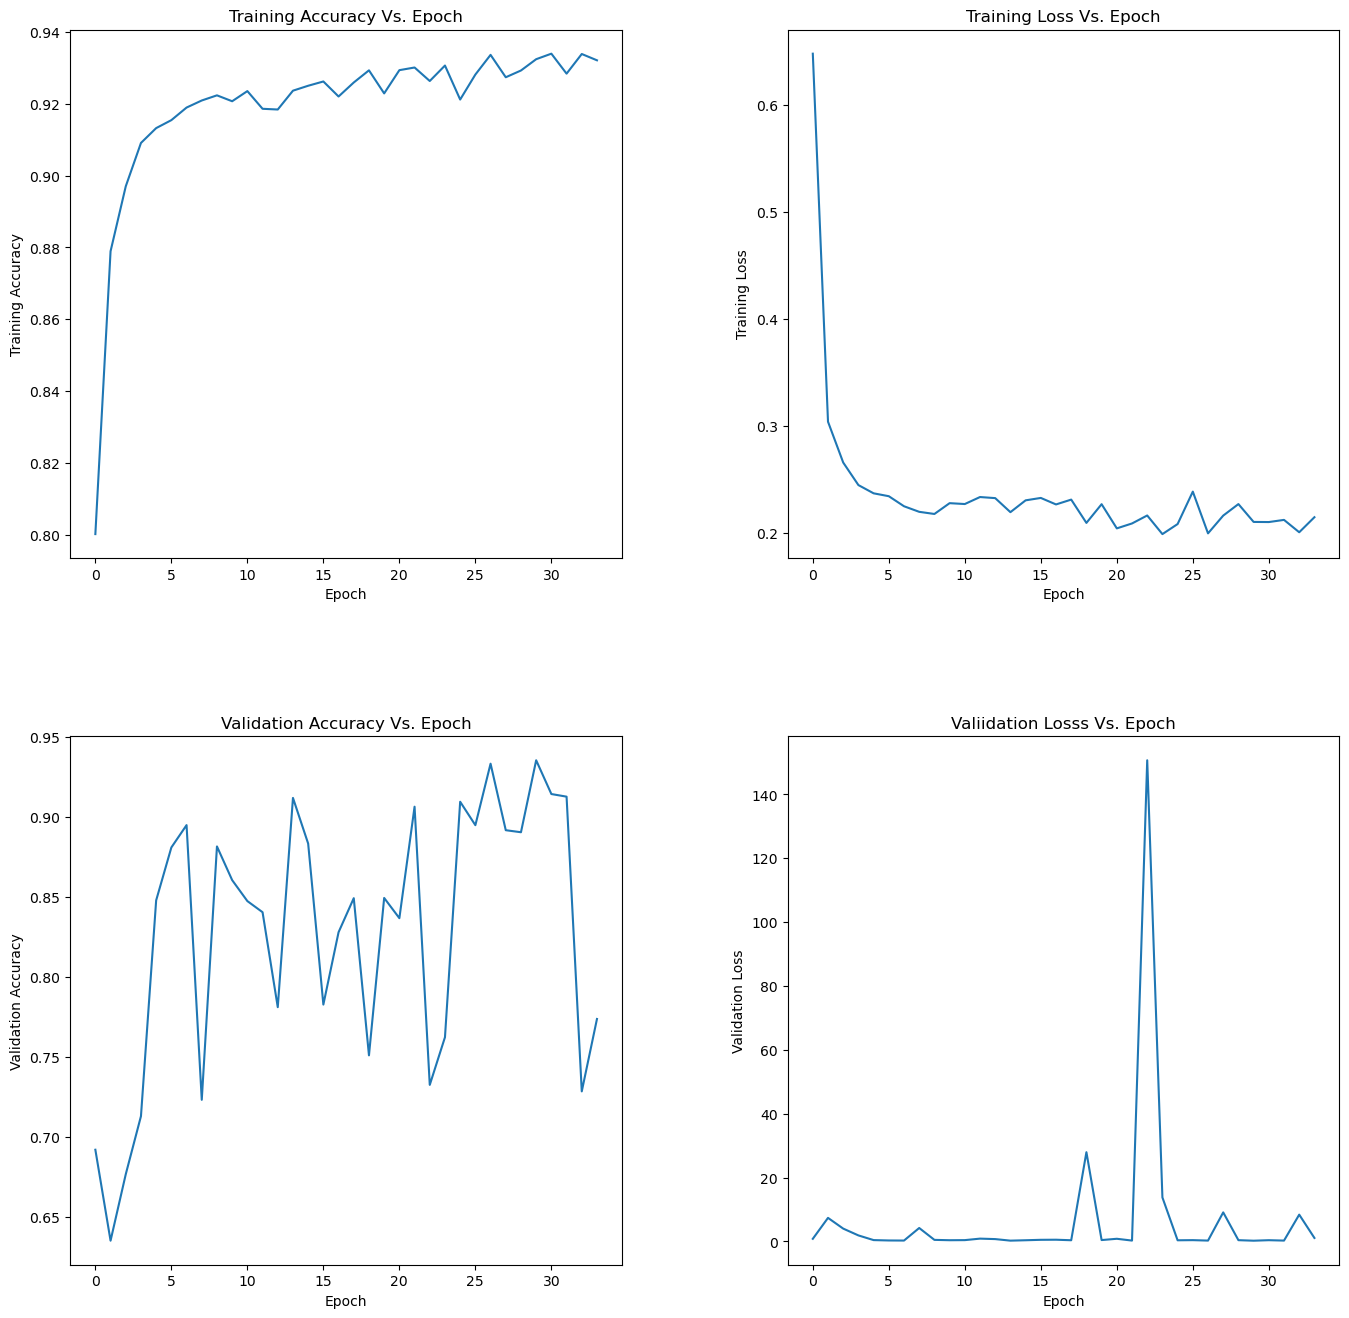

In [40]:
used_epochs = len(history4.history["accuracy"])

model4_accuracy = round((history4.history["accuracy"][used_epochs - 1]), 3)
model4_loss = round((history4.history["loss"][used_epochs - 1]), 3)
model4_val_accuracy = round((history4.history["val_accuracy"][used_epochs - 1]), 3)
model4_val_loss = round((history4.history["val_loss"][used_epochs - 1]), 3)
model4_train_time = round((endTime4 - startTime4) / 60, 3)

print("The final results for model 4:")
print(f"\nTraining Time = {model4_train_time} minutes")
print(f"Accuracy = {model4_accuracy}")
print(f"Loss = {model4_loss}")
print(f"Validation Accuracy = {model4_val_accuracy}")
print(f"Validation Loss = {model4_val_loss}\n\n")

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
figure.tight_layout(pad = 2)
figure.set_figheight(15)
figure.set_figwidth(15)

# Make a nice visualization of our test model: Training Accuracy Vs. Epoch
testAccs = history4.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[0, 0].plot(epochs, testAccs)
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Training Accuracy")
axis[0, 0].set_title("Training Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history4.history["loss"]
axis[0, 1].plot(epochs, testLosses)
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Training Loss")
axis[0, 1].set_title("Training Loss Vs. Epoch")

# Make a nice visualization of our test model: Validation Accuracy Vs. Epoch
testAccs = history4.history["val_accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[1, 0].plot(epochs, testAccs)
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Validation Accuracy")
axis[1, 0].set_title("Validation Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history4.history["val_loss"]
axis[1, 1].plot(epochs, testLosses)
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("Validation Loss")
axis[1, 1].set_title("Valiidation Losss Vs. Epoch")

plt.show

#### Analysis

* The callback function worked as intended. Although the model was supposed to train for 90 epochs, the callback function ended the training at 34 epochs.
* Definitely an improvement in the model accuracy at 93%. 
* However, somewhat troubling results when it comes to the validation accuracy. The result is much lower than the previous models at 77%. Also, the results jump all over the place over the course of the epochs.

## Part 5: Conclusion

We will now create a CSV submission file based on the model predictions to submit to Kaggle.

In [41]:
def create_submission_csv(test_dir, model):
    images_test = pd.DataFrame({'id':os.listdir(test_dir)})
    
    # Scale the test images to have pixel values in [0-1]
    generator_test = ImageDataGenerator(rescale= 1.0 / 255)

    test_data = generator_test.flow_from_dataframe(
        dataframe = images_test,
        x_col='id', # filenames
        directory=test_dir,
        class_mode=None,
        batch_size=1,
        target_size=im_size,
        shuffle=False)

    # Predict with the model
    predictions = model.predict(test_data, verbose = 1)
    
    # Create submission dataframe for kaggle submission
    submission_df = pd.DataFrame()
    submission_df['id'] = images_test['id'].apply(lambda x: x.split('.')[0])
    submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions.squeeze()))
    submission_df['label'].value_counts()
    submission_df.to_csv('submission.csv', index=False)
    
    return submission_df

In [42]:
batch_size, im_size = 256, (96, 96)

submission_df = create_submission_csv(test_dir, model4)

Found 57458 validated image filenames.
57458/57458 [==============================] - 523s 9ms/step
